In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/colabdata/WIDER"

# minimize the resolution of the images without loosing the 'Features'
IMAGE_SIZE = 224

# batch size - koliko epoch-ov
BATCH_SIZE = 5

# make data generator, rescale the images
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2)

# use data generator split data into train and validation sets
train_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

# Trigger a training generator for all the batches
for image_batch, label_batch in train_generator:
    break

# print classification labels
print(train_generator.class_indices)

# Create file with all names 
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

Found 996 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
{'WIDER_train': 0, 'WIDER_val': 1, 'wider_face_split': 2}


In [ ]:
# MobileNetV2 is a CNN architecture that seeks to perform well on mobile devices. 
# based on an inverted residual structure where the residual connections are between the bottleneck layers. 
# The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. 
# the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.
# bottleneck layer -> transformation layers -> bottleneck output
# + shortcut med bottleneck layerli


# Resolution of images
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create base model from  pre-trained model MobileNet V2
# The first layer is redundant for classification of features not required
# Hence, creating a model with EXCLUDING the top layer
# "bottleneck layer". fully-connected layers will be too specialized to the task the network was trained on
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# We will be tweaking the model with our own classifications
# don't want our tweaks to affect the layers in the 'base_model'
# disable base_model training
base_model.trainable = False

In [ ]:
# Add classification head

model = tf.keras.Sequential([
    base_model,  # base model
    # transformation layers
    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 2D Convolution network
    tf.keras.layers.Dropout(0.2),  # 20% of nodes will be dropped out
    tf.keras.layers.GlobalAveragePooling2D(),  # Pooling for data size reduction by taking an average of the adjacent nodes
    # main dense layer
    tf.keras.layers.Dense(3, activation='softmax')  # takes input from all prev nodes and gives input to all next nodes. Densely connected
])

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),  # BP optimizer [Adam/Xavier algorithms help in Optimization]
              loss='categorical_crossentropy',  # Weights are changed depending upon the 'LOSS'
              metrics=['accuracy'])  # On basis of which parameter our loss will be calculated? here we are going for accuracy

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

# train the model in 10 iterations
epochs = 10

# training 
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_2   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,626,755
Trainable params: 368,771
Non-

[0.8024193644523621, 0.8024193644523621, 0.8024193644523621, 0.774193525314331, 0.7701612710952759, 0.7862903475761414, 0.5443548560142517, 0.7137096524238586, 0.6935483813285828, 0.7943548560142517]
[0.9505585432052612, 0.49353495240211487, 0.42120370268821716, 0.3746967613697052, 0.317623108625412, 0.2906886041164398, 0.2358655333518982, 0.18040429055690765, 0.14360065758228302, 0.11269036680459976]


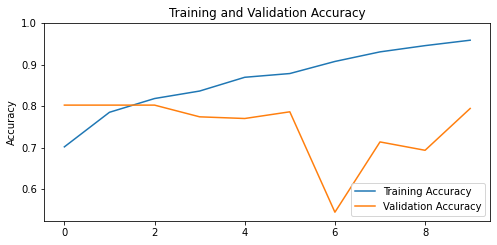

In [ ]:
# Visualizing the Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0, 1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()
print(val_acc)
print(loss)